<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss()
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy"):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_numpy"):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,039357.npy,039357.npy,Western_numpy
1,107591.npy,107591.npy,Western_numpy
2,143217.npy,143217.npy,Western_numpy
3,140623.npy,140623.npy,Western_numpy
4,147059.npy,147059.npy,Western_numpy


In [5]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2008,2008
Western_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy/122646.npy
80.0


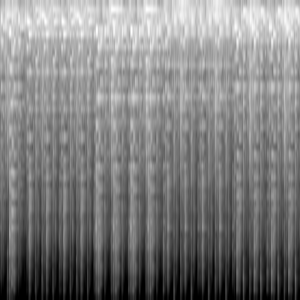

In [6]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



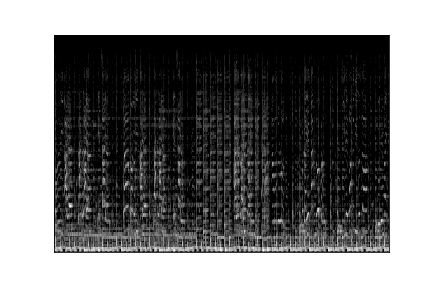

In [7]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [8]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,039357.npy,039357.npy,Western_numpy,1
1,107591.npy,107591.npy,Western_numpy,1
2,143217.npy,143217.npy,Western_numpy,1
3,140623.npy,140623.npy,Western_numpy,1
4,147059.npy,147059.npy,Western_numpy,1


In [9]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008
Western_numpy,1,2008,2008


In [10]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=42)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1405,1405
Western_numpy,1,1406,1406


In [12]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603
Western_numpy,1,602,602


In [13]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [14]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return data, label



In [15]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [16]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [17]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

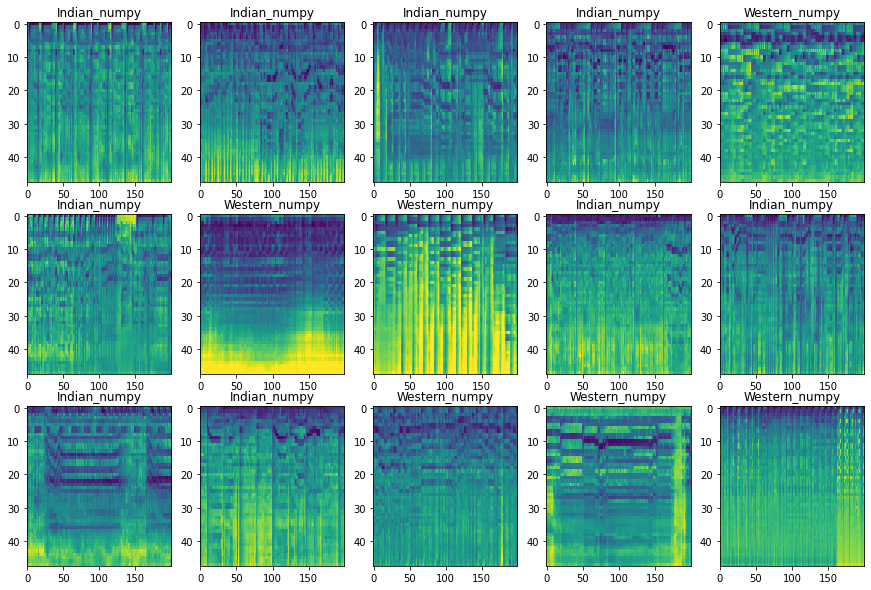

In [18]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

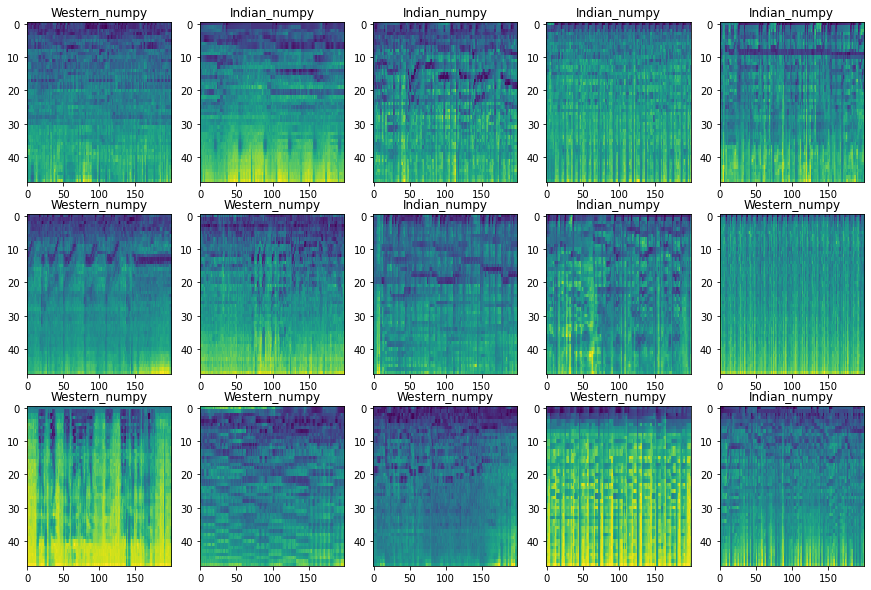

In [19]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [20]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [21]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1272.105
[1,     2] loss: 1388.895
[1,     3] loss: 1351.613
[1,     4] loss: 1199.598
[1,     5] loss: 1046.989
[1,     6] loss: 932.954
[1,     7] loss: 607.542
[1,     8] loss: 447.775
[1,     9] loss: 173.750
[1,    10] loss: 571.752
[1,    11] loss: 337.592
[1,    12] loss: 138.467
[1,    13] loss: 135.172
[1,    14] loss: 140.379
[1,    15] loss: 235.734
[1,    16] loss: 231.147
[1,    17] loss: 243.322
[1,    18] loss: 187.189
[1,    19] loss: 216.099
[1,    20] loss: 156.760
[1,    21] loss: 156.794
[1,    22] loss: 141.316
[1,    23] loss: 123.418
[1,    24] loss: 168.125
[1,    25] loss: 147.970
[1,    26] loss: 169.248
[1,    27] loss: 157.762
[1,    28] loss: 143.229
[1,    29] loss: 143.525
[1,    30] loss: 104.190
[1,    31] loss: 103.738
[1,    32] loss: 107.401
[1,    33] loss: 116.580
[1,    34] loss: 111.726
[1,    35] loss: 101.053
[1,    36] loss: 102.783
[1,    37] loss: 124.434
[1,    38] loss: 141.200
[1,    39] loss: 128.066
[1,    40] loss: 163

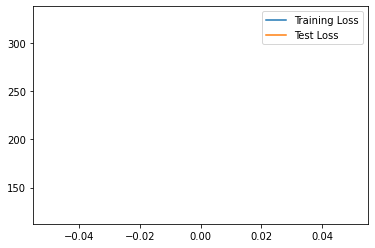

[2,     1] loss: 109.165
[2,     2] loss: 117.914
[2,     3] loss: 120.491
[2,     4] loss: 121.716
[2,     5] loss: 120.676
[2,     6] loss: 121.862
[2,     7] loss: 106.373
[2,     8] loss: 149.123
[2,     9] loss: 95.394
[2,    10] loss: 108.553
[2,    11] loss: 94.730
[2,    12] loss: 105.740
[2,    13] loss: 110.762
[2,    14] loss: 94.185
[2,    15] loss: 119.906
[2,    16] loss: 111.472
[2,    17] loss: 119.216
[2,    18] loss: 97.244
[2,    19] loss: 118.715
[2,    20] loss: 112.479
[2,    21] loss: 111.556
[2,    22] loss: 114.536
[2,    23] loss: 102.778
[2,    24] loss: 131.735
[2,    25] loss: 86.722
[2,    26] loss: 117.106
[2,    27] loss: 105.139
[2,    28] loss: 98.299
[2,    29] loss: 119.608
[2,    30] loss: 94.824
[2,    31] loss: 94.476
[2,    32] loss: 93.469
[2,    33] loss: 104.701
[2,    34] loss: 98.166
[2,    35] loss: 91.425
[2,    36] loss: 93.826
[2,    37] loss: 107.349
[2,    38] loss: 116.505
[2,    39] loss: 109.587
[2,    40] loss: 138.618
[2,    41] l

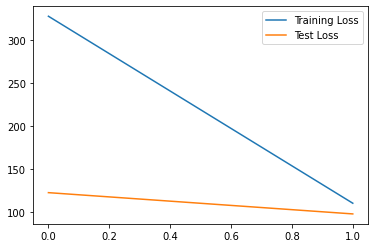

[3,     1] loss: 83.595
[3,     2] loss: 97.559
[3,     3] loss: 102.961
[3,     4] loss: 92.995
[3,     5] loss: 94.301
[3,     6] loss: 89.067
[3,     7] loss: 85.654
[3,     8] loss: 112.904
[3,     9] loss: 68.653
[3,    10] loss: 79.313
[3,    11] loss: 67.106
[3,    12] loss: 72.766
[3,    13] loss: 75.816
[3,    14] loss: 68.346
[3,    15] loss: 73.632
[3,    16] loss: 66.652
[3,    17] loss: 82.852
[3,    18] loss: 68.955
[3,    19] loss: 82.633
[3,    20] loss: 75.056
[3,    21] loss: 72.997
[3,    22] loss: 78.895
[3,    23] loss: 68.624
[3,    24] loss: 78.313
[3,    25] loss: 65.907
[3,    26] loss: 73.870
[3,    27] loss: 69.547
[3,    28] loss: 61.486
[3,    29] loss: 77.505
[3,    30] loss: 70.834
[3,    31] loss: 68.112
[3,    32] loss: 67.074
[3,    33] loss: 69.311
[3,    34] loss: 64.416
[3,    35] loss: 69.872
[3,    36] loss: 68.605
[3,    37] loss: 79.839
[3,    38] loss: 75.983
[3,    39] loss: 69.771
[3,    40] loss: 85.669
[3,    41] loss: 76.104
[3,    42] los

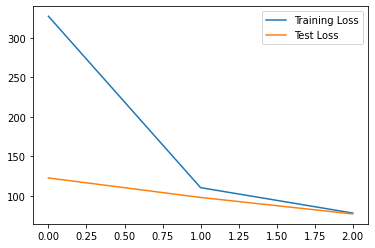

[4,     1] loss: 69.261
[4,     2] loss: 75.278
[4,     3] loss: 79.253
[4,     4] loss: 71.917
[4,     5] loss: 74.191
[4,     6] loss: 70.528
[4,     7] loss: 75.298
[4,     8] loss: 91.326
[4,     9] loss: 63.597
[4,    10] loss: 73.714
[4,    11] loss: 62.417
[4,    12] loss: 70.481
[4,    13] loss: 71.713
[4,    14] loss: 65.287
[4,    15] loss: 71.735
[4,    16] loss: 64.344
[4,    17] loss: 79.105
[4,    18] loss: 65.973
[4,    19] loss: 79.397
[4,    20] loss: 71.638
[4,    21] loss: 72.521
[4,    22] loss: 77.872
[4,    23] loss: 67.684
[4,    24] loss: 76.174
[4,    25] loss: 65.258
[4,    26] loss: 72.588
[4,    27] loss: 67.900
[4,    28] loss: 60.464
[4,    29] loss: 75.041
[4,    30] loss: 69.885
[4,    31] loss: 67.366
[4,    32] loss: 66.659
[4,    33] loss: 68.249
[4,    34] loss: 63.486
[4,    35] loss: 69.168
[4,    36] loss: 67.888
[4,    37] loss: 78.780
[4,    38] loss: 73.040
[4,    39] loss: 66.775
[4,    40] loss: 83.876
[4,    41] loss: 71.301
[4,    42] loss:

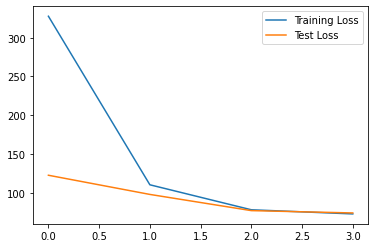

[5,     1] loss: 66.513
[5,     2] loss: 75.089
[5,     3] loss: 76.606
[5,     4] loss: 71.850
[5,     5] loss: 72.167
[5,     6] loss: 70.435
[5,     7] loss: 74.184
[5,     8] loss: 89.259
[5,     9] loss: 62.283
[5,    10] loss: 72.722
[5,    11] loss: 62.113
[5,    12] loss: 69.168
[5,    13] loss: 71.223
[5,    14] loss: 64.494
[5,    15] loss: 71.043
[5,    16] loss: 63.795
[5,    17] loss: 77.867
[5,    18] loss: 65.689
[5,    19] loss: 78.200
[5,    20] loss: 71.195
[5,    21] loss: 71.507
[5,    22] loss: 77.174
[5,    23] loss: 66.771
[5,    24] loss: 74.968
[5,    25] loss: 64.853
[5,    26] loss: 72.065
[5,    27] loss: 67.446
[5,    28] loss: 59.951
[5,    29] loss: 74.608
[5,    30] loss: 69.522
[5,    31] loss: 67.010
[5,    32] loss: 66.202
[5,    33] loss: 67.827
[5,    34] loss: 63.103
[5,    35] loss: 68.598
[5,    36] loss: 67.464
[5,    37] loss: 78.153
[5,    38] loss: 72.529
[5,    39] loss: 66.184
[5,    40] loss: 82.670
[5,    41] loss: 70.867
[5,    42] loss:

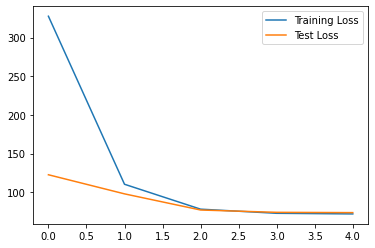

[6,     1] loss: 66.223
[6,     2] loss: 74.333
[6,     3] loss: 76.267
[6,     4] loss: 71.114
[6,     5] loss: 71.734
[6,     6] loss: 69.466
[6,     7] loss: 73.871
[6,     8] loss: 87.538
[6,     9] loss: 62.547
[6,    10] loss: 71.850
[6,    11] loss: 62.158
[6,    12] loss: 68.330
[6,    13] loss: 71.105
[6,    14] loss: 63.896
[6,    15] loss: 70.765
[6,    16] loss: 63.369
[6,    17] loss: 77.283
[6,    18] loss: 65.438
[6,    19] loss: 77.707
[6,    20] loss: 70.861
[6,    21] loss: 71.112
[6,    22] loss: 76.969
[6,    23] loss: 66.003
[6,    24] loss: 74.248
[6,    25] loss: 64.432
[6,    26] loss: 71.816
[6,    27] loss: 67.120
[6,    28] loss: 59.657
[6,    29] loss: 74.279
[6,    30] loss: 69.199
[6,    31] loss: 66.862
[6,    32] loss: 66.050
[6,    33] loss: 67.441
[6,    34] loss: 62.916
[6,    35] loss: 68.242
[6,    36] loss: 67.252
[6,    37] loss: 77.568
[6,    38] loss: 72.075
[6,    39] loss: 65.857
[6,    40] loss: 81.749
[6,    41] loss: 70.621
[6,    42] loss:

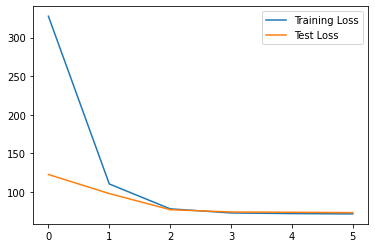

[7,     1] loss: 65.836
[7,     2] loss: 73.824
[7,     3] loss: 75.845
[7,     4] loss: 70.642
[7,     5] loss: 71.186
[7,     6] loss: 68.896
[7,     7] loss: 73.263
[7,     8] loss: 86.558
[7,     9] loss: 61.744
[7,    10] loss: 71.317
[7,    11] loss: 61.811
[7,    12] loss: 67.727
[7,    13] loss: 70.547
[7,    14] loss: 63.477
[7,    15] loss: 70.243
[7,    16] loss: 63.196
[7,    17] loss: 76.695
[7,    18] loss: 65.371
[7,    19] loss: 77.086
[7,    20] loss: 70.605
[7,    21] loss: 70.568
[7,    22] loss: 76.458
[7,    23] loss: 65.910
[7,    24] loss: 73.685
[7,    25] loss: 64.114
[7,    26] loss: 71.622
[7,    27] loss: 66.555
[7,    28] loss: 59.340
[7,    29] loss: 73.830
[7,    30] loss: 68.873
[7,    31] loss: 66.475
[7,    32] loss: 65.635
[7,    33] loss: 67.119
[7,    34] loss: 62.652
[7,    35] loss: 67.752
[7,    36] loss: 66.809
[7,    37] loss: 76.977
[7,    38] loss: 71.719
[7,    39] loss: 65.511
[7,    40] loss: 81.046
[7,    41] loss: 70.255
[7,    42] loss:

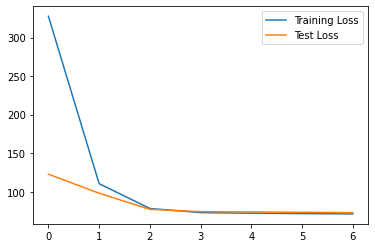

[8,     1] loss: 65.468
[8,     2] loss: 73.256
[8,     3] loss: 75.531
[8,     4] loss: 70.244
[8,     5] loss: 70.719
[8,     6] loss: 68.628
[8,     7] loss: 72.792
[8,     8] loss: 86.029
[8,     9] loss: 61.588
[8,    10] loss: 70.815
[8,    11] loss: 61.762
[8,    12] loss: 67.290
[8,    13] loss: 70.153
[8,    14] loss: 63.270
[8,    15] loss: 69.775
[8,    16] loss: 63.160
[8,    17] loss: 76.338
[8,    18] loss: 65.169
[8,    19] loss: 76.671
[8,    20] loss: 70.114
[8,    21] loss: 70.210
[8,    22] loss: 75.577
[8,    23] loss: 65.591
[8,    24] loss: 73.388
[8,    25] loss: 63.682
[8,    26] loss: 71.652
[8,    27] loss: 66.262
[8,    28] loss: 59.046
[8,    29] loss: 73.635
[8,    30] loss: 68.544
[8,    31] loss: 66.307
[8,    32] loss: 65.574
[8,    33] loss: 66.823
[8,    34] loss: 62.538
[8,    35] loss: 67.260
[8,    36] loss: 66.547
[8,    37] loss: 76.438
[8,    38] loss: 71.288
[8,    39] loss: 65.138
[8,    40] loss: 80.422
[8,    41] loss: 69.747
[8,    42] loss:

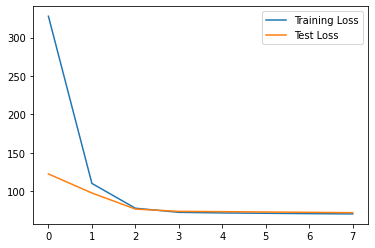

[9,     1] loss: 65.088
[9,     2] loss: 72.517
[9,     3] loss: 75.011
[9,     4] loss: 69.800
[9,     5] loss: 70.086
[9,     6] loss: 68.055
[9,     7] loss: 72.325
[9,     8] loss: 84.974
[9,     9] loss: 61.154
[9,    10] loss: 70.377
[9,    11] loss: 61.446
[9,    12] loss: 66.973
[9,    13] loss: 69.311
[9,    14] loss: 62.696
[9,    15] loss: 69.410
[9,    16] loss: 62.483
[9,    17] loss: 75.848
[9,    18] loss: 65.084
[9,    19] loss: 75.922
[9,    20] loss: 69.717
[9,    21] loss: 69.765
[9,    22] loss: 74.888
[9,    23] loss: 64.940
[9,    24] loss: 72.845
[9,    25] loss: 63.198
[9,    26] loss: 71.119
[9,    27] loss: 65.576
[9,    28] loss: 58.659
[9,    29] loss: 72.952
[9,    30] loss: 68.107
[9,    31] loss: 65.718
[9,    32] loss: 64.919
[9,    33] loss: 66.599
[9,    34] loss: 62.118
[9,    35] loss: 66.552
[9,    36] loss: 65.862
[9,    37] loss: 75.443
[9,    38] loss: 70.998
[9,    39] loss: 65.221
[9,    40] loss: 79.717
[9,    41] loss: 69.469
[9,    42] loss:

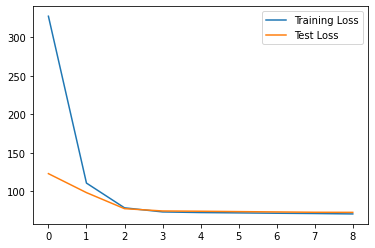

[10,     1] loss: 64.996
[10,     2] loss: 71.494
[10,     3] loss: 74.973
[10,     4] loss: 70.151
[10,     5] loss: 69.274
[10,     6] loss: 68.446
[10,     7] loss: 72.639
[10,     8] loss: 84.227
[10,     9] loss: 63.134
[10,    10] loss: 70.497
[10,    11] loss: 61.764
[10,    12] loss: 67.659
[10,    13] loss: 68.411
[10,    14] loss: 62.878
[10,    15] loss: 68.663
[10,    16] loss: 62.508
[10,    17] loss: 75.702
[10,    18] loss: 64.417
[10,    19] loss: 75.193
[10,    20] loss: 69.031
[10,    21] loss: 68.987
[10,    22] loss: 73.710
[10,    23] loss: 64.154
[10,    24] loss: 72.683
[10,    25] loss: 62.465
[10,    26] loss: 70.963
[10,    27] loss: 65.060
[10,    28] loss: 58.043
[10,    29] loss: 72.742
[10,    30] loss: 67.178
[10,    31] loss: 65.238
[10,    32] loss: 64.420
[10,    33] loss: 65.651
[10,    34] loss: 61.764
[10,    35] loss: 65.137
[10,    36] loss: 65.162
[10,    37] loss: 73.798
[10,    38] loss: 69.794
[10,    39] loss: 64.266
[10,    40] loss: 78.525


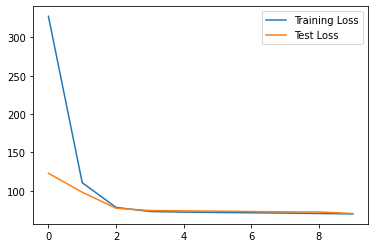

[11,     1] loss: 63.112
[11,     2] loss: 69.478
[11,     3] loss: 72.799
[11,     4] loss: 67.975
[11,     5] loss: 67.283
[11,     6] loss: 65.397
[11,     7] loss: 69.194
[11,     8] loss: 81.185
[11,     9] loss: 58.707
[11,    10] loss: 67.726
[11,    11] loss: 59.783
[11,    12] loss: 64.851
[11,    13] loss: 66.372
[11,    14] loss: 59.394
[11,    15] loss: 66.437
[11,    16] loss: 62.301
[11,    17] loss: 72.272
[11,    18] loss: 61.926
[11,    19] loss: 71.872
[11,    20] loss: 66.922
[11,    21] loss: 65.948
[11,    22] loss: 70.198
[11,    23] loss: 62.163
[11,    24] loss: 69.790
[11,    25] loss: 59.823
[11,    26] loss: 67.095
[11,    27] loss: 61.121
[11,    28] loss: 55.643
[11,    29] loss: 69.454
[11,    30] loss: 63.892
[11,    31] loss: 61.979
[11,    32] loss: 59.266
[11,    33] loss: 61.735
[11,    34] loss: 56.968
[11,    35] loss: 59.442
[11,    36] loss: 60.017
[11,    37] loss: 68.109
[11,    38] loss: 64.267
[11,    39] loss: 61.869
[11,    40] loss: 72.900


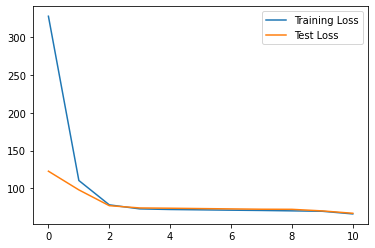

[12,     1] loss: 59.929
[12,     2] loss: 61.372
[12,     3] loss: 68.705
[12,     4] loss: 64.521
[12,     5] loss: 61.098
[12,     6] loss: 59.489
[12,     7] loss: 65.385
[12,     8] loss: 73.087
[12,     9] loss: 59.749
[12,    10] loss: 67.852
[12,    11] loss: 57.994
[12,    12] loss: 65.502
[12,    13] loss: 60.094
[12,    14] loss: 57.143
[12,    15] loss: 59.840
[12,    16] loss: 60.635
[12,    17] loss: 67.286
[12,    18] loss: 57.921
[12,    19] loss: 63.549
[12,    20] loss: 59.834
[12,    21] loss: 61.707
[12,    22] loss: 64.729
[12,    23] loss: 56.477
[12,    24] loss: 63.685
[12,    25] loss: 56.958
[12,    26] loss: 61.017
[12,    27] loss: 55.676
[12,    28] loss: 53.340
[12,    29] loss: 67.260
[12,    30] loss: 58.958
[12,    31] loss: 59.063
[12,    32] loss: 55.664
[12,    33] loss: 58.187
[12,    34] loss: 53.374
[12,    35] loss: 55.882
[12,    36] loss: 56.095
[12,    37] loss: 64.331
[12,    38] loss: 60.883
[12,    39] loss: 57.298
[12,    40] loss: 69.237


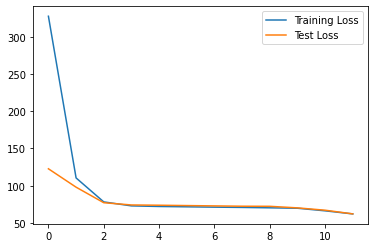

[13,     1] loss: 55.176
[13,     2] loss: 58.318
[13,     3] loss: 65.574
[13,     4] loss: 60.987
[13,     5] loss: 59.266
[13,     6] loss: 55.473
[13,     7] loss: 59.203
[13,     8] loss: 68.032
[13,     9] loss: 52.974
[13,    10] loss: 60.856
[13,    11] loss: 55.258
[13,    12] loss: 58.489
[13,    13] loss: 57.817
[13,    14] loss: 53.472
[13,    15] loss: 58.411
[13,    16] loss: 56.051
[13,    17] loss: 64.276
[13,    18] loss: 55.278
[13,    19] loss: 60.957
[13,    20] loss: 57.164
[13,    21] loss: 59.837
[13,    22] loss: 62.340
[13,    23] loss: 53.747
[13,    24] loss: 61.460
[13,    25] loss: 54.843
[13,    26] loss: 58.552
[13,    27] loss: 53.696
[13,    28] loss: 51.825
[13,    29] loss: 65.016
[13,    30] loss: 57.543
[13,    31] loss: 57.048
[13,    32] loss: 54.161
[13,    33] loss: 56.281
[13,    34] loss: 51.667
[13,    35] loss: 54.083
[13,    36] loss: 54.340
[13,    37] loss: 61.109
[13,    38] loss: 59.267
[13,    39] loss: 55.210
[13,    40] loss: 66.947


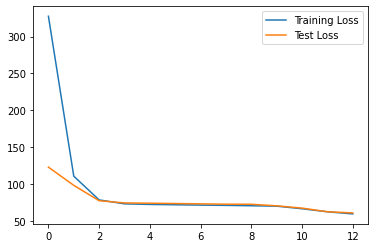

[14,     1] loss: 53.488
[14,     2] loss: 55.831
[14,     3] loss: 63.535
[14,     4] loss: 59.519
[14,     5] loss: 57.624
[14,     6] loss: 53.330
[14,     7] loss: 57.778
[14,     8] loss: 64.080
[14,     9] loss: 51.506
[14,    10] loss: 58.933
[14,    11] loss: 54.098
[14,    12] loss: 56.182
[14,    13] loss: 56.161
[14,    14] loss: 52.006
[14,    15] loss: 56.672
[14,    16] loss: 54.686
[14,    17] loss: 61.266
[14,    18] loss: 53.156
[14,    19] loss: 59.152
[14,    20] loss: 55.021
[14,    21] loss: 57.826
[14,    22] loss: 60.014
[14,    23] loss: 51.818
[14,    24] loss: 58.346
[14,    25] loss: 53.242
[14,    26] loss: 56.049
[14,    27] loss: 51.656
[14,    28] loss: 50.430
[14,    29] loss: 62.619
[14,    30] loss: 55.636
[14,    31] loss: 55.614
[14,    32] loss: 52.832
[14,    33] loss: 54.292
[14,    34] loss: 50.372
[14,    35] loss: 52.256
[14,    36] loss: 52.060
[14,    37] loss: 58.176
[14,    38] loss: 56.883
[14,    39] loss: 53.171
[14,    40] loss: 63.889


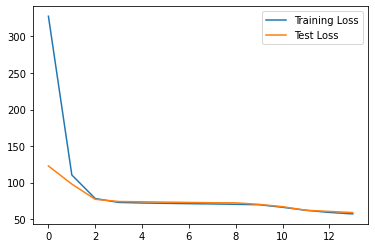

[15,     1] loss: 51.640
[15,     2] loss: 53.987
[15,     3] loss: 62.081
[15,     4] loss: 57.737
[15,     5] loss: 55.748
[15,     6] loss: 51.812
[15,     7] loss: 57.093
[15,     8] loss: 61.033
[15,     9] loss: 50.495
[15,    10] loss: 57.169
[15,    11] loss: 52.207
[15,    12] loss: 54.714
[15,    13] loss: 54.523
[15,    14] loss: 50.504
[15,    15] loss: 55.411
[15,    16] loss: 53.080
[15,    17] loss: 57.923
[15,    18] loss: 51.785
[15,    19] loss: 58.372
[15,    20] loss: 52.870
[15,    21] loss: 56.545
[15,    22] loss: 60.429
[15,    23] loss: 50.062
[15,    24] loss: 58.077
[15,    25] loss: 52.604
[15,    26] loss: 54.369
[15,    27] loss: 53.052
[15,    28] loss: 49.574
[15,    29] loss: 62.004
[15,    30] loss: 55.684
[15,    31] loss: 54.577
[15,    32] loss: 53.542
[15,    33] loss: 52.652
[15,    34] loss: 50.332
[15,    35] loss: 51.482
[15,    36] loss: 51.289
[15,    37] loss: 56.008
[15,    38] loss: 55.985
[15,    39] loss: 53.048
[15,    40] loss: 61.859


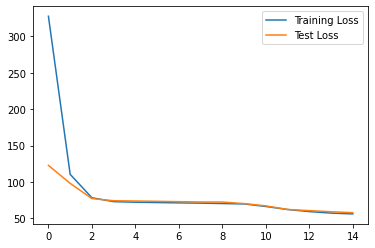

[16,     1] loss: 50.333
[16,     2] loss: 53.102
[16,     3] loss: 60.156
[16,     4] loss: 57.458
[16,     5] loss: 54.666
[16,     6] loss: 50.436
[16,     7] loss: 55.369
[16,     8] loss: 59.690
[16,     9] loss: 50.392
[16,    10] loss: 54.777
[16,    11] loss: 52.285
[16,    12] loss: 52.985
[16,    13] loss: 53.237
[16,    14] loss: 50.003
[16,    15] loss: 54.033
[16,    16] loss: 51.155
[16,    17] loss: 56.212
[16,    18] loss: 50.729
[16,    19] loss: 55.785
[16,    20] loss: 51.854
[16,    21] loss: 54.308
[16,    22] loss: 56.820
[16,    23] loss: 48.808
[16,    24] loss: 55.788
[16,    25] loss: 50.353
[16,    26] loss: 52.806
[16,    27] loss: 50.370
[16,    28] loss: 48.772
[16,    29] loss: 58.574
[16,    30] loss: 53.656
[16,    31] loss: 53.618
[16,    32] loss: 51.365
[16,    33] loss: 51.773
[16,    34] loss: 48.256
[16,    35] loss: 50.365
[16,    36] loss: 49.757
[16,    37] loss: 54.145
[16,    38] loss: 53.818
[16,    39] loss: 50.970
[16,    40] loss: 59.507


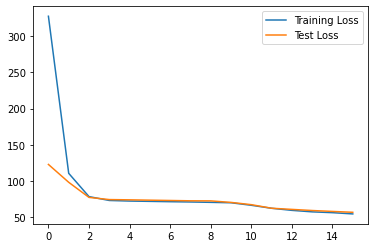

[17,     1] loss: 49.231
[17,     2] loss: 51.320
[17,     3] loss: 58.430
[17,     4] loss: 54.961
[17,     5] loss: 53.068
[17,     6] loss: 48.627
[17,     7] loss: 53.537
[17,     8] loss: 57.538
[17,     9] loss: 47.988
[17,    10] loss: 53.570
[17,    11] loss: 50.375
[17,    12] loss: 51.545
[17,    13] loss: 51.154
[17,    14] loss: 48.915
[17,    15] loss: 52.253
[17,    16] loss: 49.104
[17,    17] loss: 54.271
[17,    18] loss: 48.928
[17,    19] loss: 54.145
[17,    20] loss: 50.093
[17,    21] loss: 52.898
[17,    22] loss: 55.169
[17,    23] loss: 47.496
[17,    24] loss: 54.031
[17,    25] loss: 49.233
[17,    26] loss: 50.779
[17,    27] loss: 48.355
[17,    28] loss: 47.422
[17,    29] loss: 56.679
[17,    30] loss: 52.302
[17,    31] loss: 52.339
[17,    32] loss: 50.423
[17,    33] loss: 50.775
[17,    34] loss: 47.418
[17,    35] loss: 49.583
[17,    36] loss: 48.999
[17,    37] loss: 52.837
[17,    38] loss: 52.847
[17,    39] loss: 49.888
[17,    40] loss: 58.263


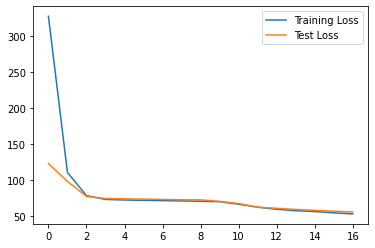

[18,     1] loss: 48.175
[18,     2] loss: 50.354
[18,     3] loss: 56.892
[18,     4] loss: 53.163
[18,     5] loss: 51.911
[18,     6] loss: 47.614
[18,     7] loss: 52.446
[18,     8] loss: 55.786
[18,     9] loss: 47.117
[18,    10] loss: 52.314
[18,    11] loss: 49.321
[18,    12] loss: 50.785
[18,    13] loss: 49.914
[18,    14] loss: 48.335
[18,    15] loss: 50.667
[18,    16] loss: 47.729
[18,    17] loss: 52.685
[18,    18] loss: 47.839
[18,    19] loss: 52.781
[18,    20] loss: 48.924
[18,    21] loss: 51.796
[18,    22] loss: 53.988
[18,    23] loss: 46.787
[18,    24] loss: 53.220
[18,    25] loss: 48.384
[18,    26] loss: 49.640
[18,    27] loss: 47.492
[18,    28] loss: 46.334
[18,    29] loss: 55.672
[18,    30] loss: 51.032
[18,    31] loss: 51.393
[18,    32] loss: 49.390
[18,    33] loss: 49.758
[18,    34] loss: 46.495
[18,    35] loss: 48.776
[18,    36] loss: 48.064
[18,    37] loss: 51.448
[18,    38] loss: 51.823
[18,    39] loss: 48.453
[18,    40] loss: 56.909


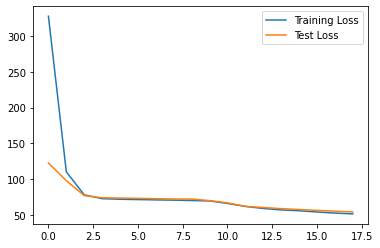

[19,     1] loss: 47.153
[19,     2] loss: 48.990
[19,     3] loss: 55.357
[19,     4] loss: 51.578
[19,     5] loss: 50.854
[19,     6] loss: 46.725
[19,     7] loss: 51.246
[19,     8] loss: 54.333
[19,     9] loss: 46.374
[19,    10] loss: 51.287
[19,    11] loss: 48.548
[19,    12] loss: 50.034
[19,    13] loss: 48.866
[19,    14] loss: 47.615
[19,    15] loss: 49.529
[19,    16] loss: 46.556
[19,    17] loss: 51.480
[19,    18] loss: 46.959
[19,    19] loss: 51.552
[19,    20] loss: 47.692
[19,    21] loss: 50.751
[19,    22] loss: 52.678
[19,    23] loss: 45.869
[19,    24] loss: 51.649
[19,    25] loss: 47.639
[19,    26] loss: 48.372
[19,    27] loss: 46.711
[19,    28] loss: 45.448
[19,    29] loss: 54.445
[19,    30] loss: 50.113
[19,    31] loss: 50.228
[19,    32] loss: 48.512
[19,    33] loss: 48.639
[19,    34] loss: 45.697
[19,    35] loss: 47.661
[19,    36] loss: 47.057
[19,    37] loss: 50.192
[19,    38] loss: 50.570
[19,    39] loss: 47.261
[19,    40] loss: 55.390


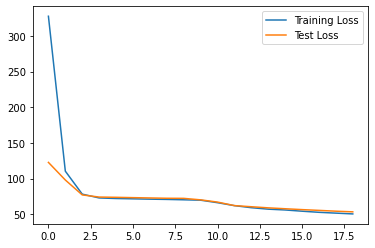

[20,     1] loss: 46.272
[20,     2] loss: 48.094
[20,     3] loss: 54.099
[20,     4] loss: 50.612
[20,     5] loss: 49.583
[20,     6] loss: 46.037
[20,     7] loss: 50.808
[20,     8] loss: 53.108
[20,     9] loss: 45.822
[20,    10] loss: 50.641
[20,    11] loss: 47.601
[20,    12] loss: 49.064
[20,    13] loss: 48.503
[20,    14] loss: 46.753
[20,    15] loss: 48.750
[20,    16] loss: 46.045
[20,    17] loss: 50.307
[20,    18] loss: 46.134
[20,    19] loss: 50.758
[20,    20] loss: 46.569
[20,    21] loss: 49.645
[20,    22] loss: 52.212
[20,    23] loss: 45.033
[20,    24] loss: 50.244
[20,    25] loss: 47.233
[20,    26] loss: 47.543
[20,    27] loss: 46.085
[20,    28] loss: 44.900
[20,    29] loss: 53.451
[20,    30] loss: 49.487
[20,    31] loss: 49.521
[20,    32] loss: 47.474
[20,    33] loss: 47.923
[20,    34] loss: 44.651
[20,    35] loss: 46.913
[20,    36] loss: 46.275
[20,    37] loss: 49.052
[20,    38] loss: 49.604
[20,    39] loss: 46.466
[20,    40] loss: 54.428


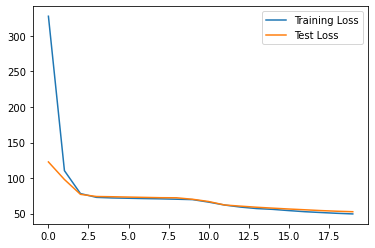

[21,     1] loss: 45.655
[21,     2] loss: 46.988
[21,     3] loss: 52.732
[21,     4] loss: 49.744
[21,     5] loss: 48.477
[21,     6] loss: 44.837
[21,     7] loss: 49.205
[21,     8] loss: 52.015
[21,     9] loss: 44.838
[21,    10] loss: 49.271
[21,    11] loss: 47.008
[21,    12] loss: 47.704
[21,    13] loss: 47.153
[21,    14] loss: 45.979
[21,    15] loss: 47.614
[21,    16] loss: 44.875
[21,    17] loss: 49.458
[21,    18] loss: 45.209
[21,    19] loss: 49.465
[21,    20] loss: 46.038
[21,    21] loss: 48.295
[21,    22] loss: 49.865
[21,    23] loss: 43.531
[21,    24] loss: 48.981
[21,    25] loss: 45.622
[21,    26] loss: 46.479
[21,    27] loss: 44.949
[21,    28] loss: 44.138
[21,    29] loss: 52.426
[21,    30] loss: 48.321
[21,    31] loss: 48.384
[21,    32] loss: 46.671
[21,    33] loss: 46.878
[21,    34] loss: 43.945
[21,    35] loss: 45.952
[21,    36] loss: 45.298
[21,    37] loss: 48.086
[21,    38] loss: 48.563
[21,    39] loss: 45.277
[21,    40] loss: 53.209


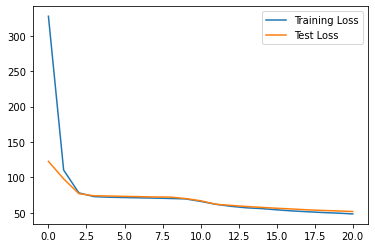

[22,     1] loss: 44.854
[22,     2] loss: 46.320
[22,     3] loss: 51.528
[22,     4] loss: 48.544
[22,     5] loss: 47.520
[22,     6] loss: 44.078
[22,     7] loss: 48.362
[22,     8] loss: 50.975
[22,     9] loss: 44.239
[22,    10] loss: 48.564
[22,    11] loss: 46.080
[22,    12] loss: 46.759
[22,    13] loss: 46.602
[22,    14] loss: 45.060
[22,    15] loss: 46.935
[22,    16] loss: 43.889
[22,    17] loss: 48.205
[22,    18] loss: 44.433
[22,    19] loss: 48.342
[22,    20] loss: 44.881
[22,    21] loss: 47.390
[22,    22] loss: 48.970
[22,    23] loss: 42.977
[22,    24] loss: 47.959
[22,    25] loss: 44.933
[22,    26] loss: 46.009
[22,    27] loss: 44.222
[22,    28] loss: 43.245
[22,    29] loss: 51.323
[22,    30] loss: 47.611
[22,    31] loss: 47.462
[22,    32] loss: 46.020
[22,    33] loss: 46.155
[22,    34] loss: 43.333
[22,    35] loss: 45.079
[22,    36] loss: 44.697
[22,    37] loss: 47.050
[22,    38] loss: 47.893
[22,    39] loss: 44.509
[22,    40] loss: 52.415


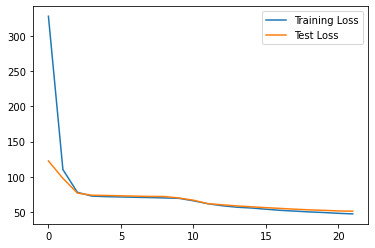

[23,     1] loss: 44.383
[23,     2] loss: 45.456
[23,     3] loss: 50.697
[23,     4] loss: 47.925
[23,     5] loss: 46.859
[23,     6] loss: 43.254
[23,     7] loss: 48.002
[23,     8] loss: 50.170
[23,     9] loss: 43.656
[23,    10] loss: 47.988
[23,    11] loss: 45.566
[23,    12] loss: 45.861
[23,    13] loss: 46.092
[23,    14] loss: 44.556
[23,    15] loss: 46.141
[23,    16] loss: 43.249
[23,    17] loss: 47.314
[23,    18] loss: 43.867
[23,    19] loss: 47.459
[23,    20] loss: 44.401
[23,    21] loss: 46.674
[23,    22] loss: 47.851
[23,    23] loss: 42.077
[23,    24] loss: 47.138
[23,    25] loss: 44.254
[23,    26] loss: 45.041
[23,    27] loss: 43.621
[23,    28] loss: 42.704
[23,    29] loss: 50.473
[23,    30] loss: 46.820
[23,    31] loss: 46.807
[23,    32] loss: 45.282
[23,    33] loss: 45.356
[23,    34] loss: 42.590
[23,    35] loss: 44.476
[23,    36] loss: 44.057
[23,    37] loss: 46.118
[23,    38] loss: 47.216
[23,    39] loss: 43.909
[23,    40] loss: 51.616


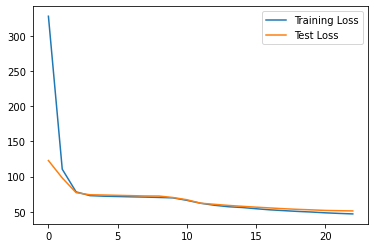

[24,     1] loss: 43.923
[24,     2] loss: 44.804
[24,     3] loss: 50.055
[24,     4] loss: 47.526
[24,     5] loss: 46.201
[24,     6] loss: 42.688
[24,     7] loss: 47.922
[24,     8] loss: 49.403
[24,     9] loss: 43.250
[24,    10] loss: 47.812
[24,    11] loss: 45.078
[24,    12] loss: 45.322
[24,    13] loss: 46.047
[24,    14] loss: 44.213
[24,    15] loss: 45.523
[24,    16] loss: 43.111
[24,    17] loss: 46.708
[24,    18] loss: 43.288
[24,    19] loss: 46.957
[24,    20] loss: 44.244
[24,    21] loss: 45.903
[24,    22] loss: 47.301
[24,    23] loss: 41.723
[24,    24] loss: 46.393
[24,    25] loss: 43.852
[24,    26] loss: 44.504
[24,    27] loss: 42.900
[24,    28] loss: 42.079
[24,    29] loss: 49.766
[24,    30] loss: 46.026
[24,    31] loss: 46.143
[24,    32] loss: 44.682
[24,    33] loss: 44.806
[24,    34] loss: 41.894
[24,    35] loss: 43.685
[24,    36] loss: 43.325
[24,    37] loss: 45.313
[24,    38] loss: 46.382
[24,    39] loss: 43.231
[24,    40] loss: 50.537


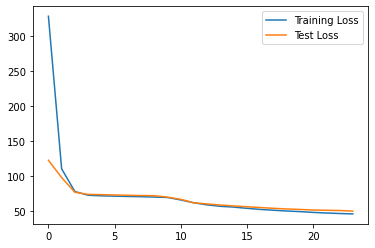

[25,     1] loss: 43.057
[25,     2] loss: 44.414
[25,     3] loss: 49.105
[25,     4] loss: 46.394
[25,     5] loss: 45.407
[25,     6] loss: 42.236
[25,     7] loss: 46.774
[25,     8] loss: 48.211
[25,     9] loss: 43.371
[25,    10] loss: 47.446
[25,    11] loss: 44.285
[25,    12] loss: 45.464
[25,    13] loss: 45.697
[25,    14] loss: 43.322
[25,    15] loss: 45.392
[25,    16] loss: 43.308
[25,    17] loss: 45.873
[25,    18] loss: 43.259
[25,    19] loss: 46.404
[25,    20] loss: 43.375
[25,    21] loss: 45.317
[25,    22] loss: 47.446
[25,    23] loss: 41.064
[25,    24] loss: 45.596
[25,    25] loss: 43.212
[25,    26] loss: 44.409
[25,    27] loss: 42.322
[25,    28] loss: 42.081
[25,    29] loss: 48.949
[25,    30] loss: 46.062
[25,    31] loss: 45.319
[25,    32] loss: 44.356
[25,    33] loss: 44.271
[25,    34] loss: 41.694
[25,    35] loss: 43.157
[25,    36] loss: 42.659
[25,    37] loss: 44.717
[25,    38] loss: 45.610
[25,    39] loss: 42.837
[25,    40] loss: 49.528


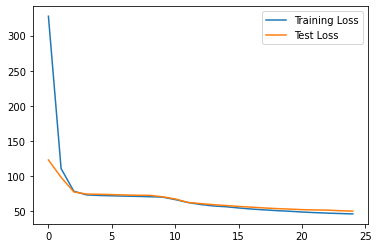

[26,     1] loss: 42.426
[26,     2] loss: 44.023
[26,     3] loss: 47.858
[26,     4] loss: 45.982
[26,     5] loss: 44.996
[26,     6] loss: 41.875
[26,     7] loss: 45.706
[26,     8] loss: 47.441
[26,     9] loss: 42.867
[26,    10] loss: 46.148
[26,    11] loss: 43.890
[26,    12] loss: 44.591
[26,    13] loss: 44.439
[26,    14] loss: 42.643
[26,    15] loss: 44.803
[26,    16] loss: 41.818
[26,    17] loss: 45.068
[26,    18] loss: 42.773
[26,    19] loss: 45.708
[26,    20] loss: 42.483
[26,    21] loss: 45.243
[26,    22] loss: 47.427
[26,    23] loss: 40.067
[26,    24] loss: 45.378
[26,    25] loss: 43.510
[26,    26] loss: 43.065
[26,    27] loss: 43.022
[26,    28] loss: 41.211
[26,    29] loss: 48.806
[26,    30] loss: 45.298
[26,    31] loss: 44.870
[26,    32] loss: 43.298
[26,    33] loss: 44.006
[26,    34] loss: 40.514
[26,    35] loss: 42.713
[26,    36] loss: 42.053
[26,    37] loss: 43.543
[26,    38] loss: 45.163
[26,    39] loss: 42.084
[26,    40] loss: 48.755


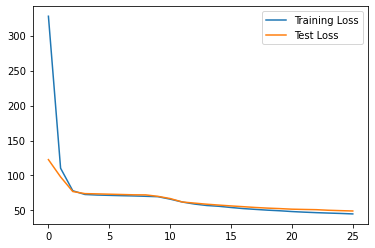

[27,     1] loss: 41.822
[27,     2] loss: 42.961
[27,     3] loss: 46.964
[27,     4] loss: 45.087
[27,     5] loss: 44.017
[27,     6] loss: 40.400
[27,     7] loss: 44.753
[27,     8] loss: 46.353
[27,     9] loss: 41.393
[27,    10] loss: 44.684
[27,    11] loss: 43.403
[27,    12] loss: 42.975
[27,    13] loss: 43.398
[27,    14] loss: 42.345
[27,    15] loss: 43.226
[27,    16] loss: 41.249
[27,    17] loss: 45.316
[27,    18] loss: 41.583
[27,    19] loss: 45.141
[27,    20] loss: 42.832
[27,    21] loss: 44.174
[27,    22] loss: 44.984
[27,    23] loss: 39.585
[27,    24] loss: 44.030
[27,    25] loss: 42.456
[27,    26] loss: 42.259
[27,    27] loss: 41.907
[27,    28] loss: 40.940
[27,    29] loss: 47.752
[27,    30] loss: 44.227
[27,    31] loss: 44.688
[27,    32] loss: 42.609
[27,    33] loss: 43.835
[27,    34] loss: 40.187
[27,    35] loss: 42.355
[27,    36] loss: 41.462
[27,    37] loss: 42.946
[27,    38] loss: 44.429
[27,    39] loss: 41.551
[27,    40] loss: 48.211


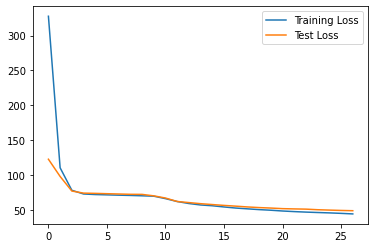

[28,     1] loss: 41.360
[28,     2] loss: 42.869
[28,     3] loss: 46.611
[28,     4] loss: 44.688
[28,     5] loss: 43.810
[28,     6] loss: 40.140
[28,     7] loss: 44.493
[28,     8] loss: 45.397
[28,     9] loss: 40.794
[28,    10] loss: 44.259
[28,    11] loss: 42.878
[28,    12] loss: 42.271
[28,    13] loss: 43.332
[28,    14] loss: 41.901
[28,    15] loss: 42.537
[28,    16] loss: 40.996
[28,    17] loss: 44.604
[28,    18] loss: 41.310
[28,    19] loss: 44.733
[28,    20] loss: 42.103
[28,    21] loss: 43.052
[28,    22] loss: 44.647
[28,    23] loss: 38.928
[28,    24] loss: 43.645
[28,    25] loss: 41.372
[28,    26] loss: 41.731
[28,    27] loss: 40.891
[28,    28] loss: 39.736
[28,    29] loss: 46.702
[28,    30] loss: 43.204
[28,    31] loss: 43.625
[28,    32] loss: 41.861
[28,    33] loss: 42.209
[28,    34] loss: 39.676
[28,    35] loss: 41.152
[28,    36] loss: 40.515
[28,    37] loss: 42.187
[28,    38] loss: 43.322
[28,    39] loss: 40.619
[28,    40] loss: 47.160


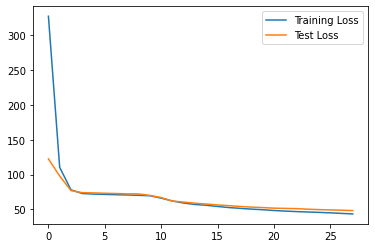

[29,     1] loss: 40.614
[29,     2] loss: 41.739
[29,     3] loss: 45.299
[29,     4] loss: 44.028
[29,     5] loss: 42.920
[29,     6] loss: 39.472
[29,     7] loss: 43.436
[29,     8] loss: 44.452
[29,     9] loss: 40.443
[29,    10] loss: 43.281
[29,    11] loss: 42.253
[29,    12] loss: 41.640
[29,    13] loss: 41.940
[29,    14] loss: 40.841
[29,    15] loss: 41.803
[29,    16] loss: 39.259
[29,    17] loss: 42.726
[29,    18] loss: 40.273
[29,    19] loss: 43.132
[29,    20] loss: 40.357
[29,    21] loss: 42.313
[29,    22] loss: 43.619
[29,    23] loss: 38.039
[29,    24] loss: 42.376
[29,    25] loss: 40.313
[29,    26] loss: 40.446
[29,    27] loss: 39.622
[29,    28] loss: 38.915
[29,    29] loss: 45.380
[29,    30] loss: 42.339
[29,    31] loss: 42.238
[29,    32] loss: 40.905
[29,    33] loss: 41.180
[29,    34] loss: 38.766
[29,    35] loss: 40.306
[29,    36] loss: 39.630
[29,    37] loss: 41.058
[29,    38] loss: 42.224
[29,    39] loss: 39.726
[29,    40] loss: 45.940


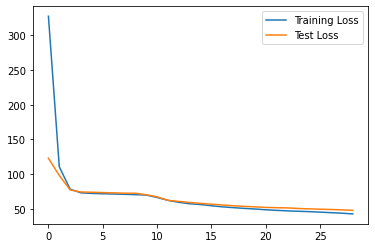

[30,     1] loss: 39.807
[30,     2] loss: 40.755
[30,     3] loss: 44.345
[30,     4] loss: 42.751
[30,     5] loss: 41.964
[30,     6] loss: 38.842
[30,     7] loss: 42.780
[30,     8] loss: 43.460
[30,     9] loss: 39.333
[30,    10] loss: 42.580
[30,    11] loss: 41.459
[30,    12] loss: 40.387
[30,    13] loss: 41.184
[30,    14] loss: 39.873
[30,    15] loss: 40.884
[30,    16] loss: 38.265
[30,    17] loss: 41.723
[30,    18] loss: 39.332
[30,    19] loss: 42.184
[30,    20] loss: 39.204
[30,    21] loss: 41.497
[30,    22] loss: 42.582
[30,    23] loss: 37.382
[30,    24] loss: 41.151
[30,    25] loss: 39.620
[30,    26] loss: 39.255
[30,    27] loss: 38.860
[30,    28] loss: 38.104
[30,    29] loss: 44.581
[30,    30] loss: 41.259
[30,    31] loss: 41.304
[30,    32] loss: 40.183
[30,    33] loss: 40.290
[30,    34] loss: 37.850
[30,    35] loss: 39.607
[30,    36] loss: 38.926
[30,    37] loss: 40.274
[30,    38] loss: 41.216
[30,    39] loss: 39.107
[30,    40] loss: 45.176


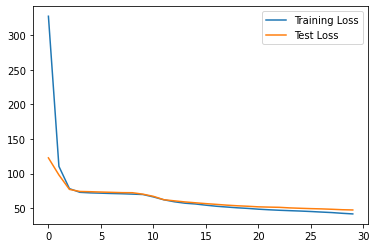

Finished Training


In [23]:
train_loss_graph = []
test_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)
          

print('Finished Training')

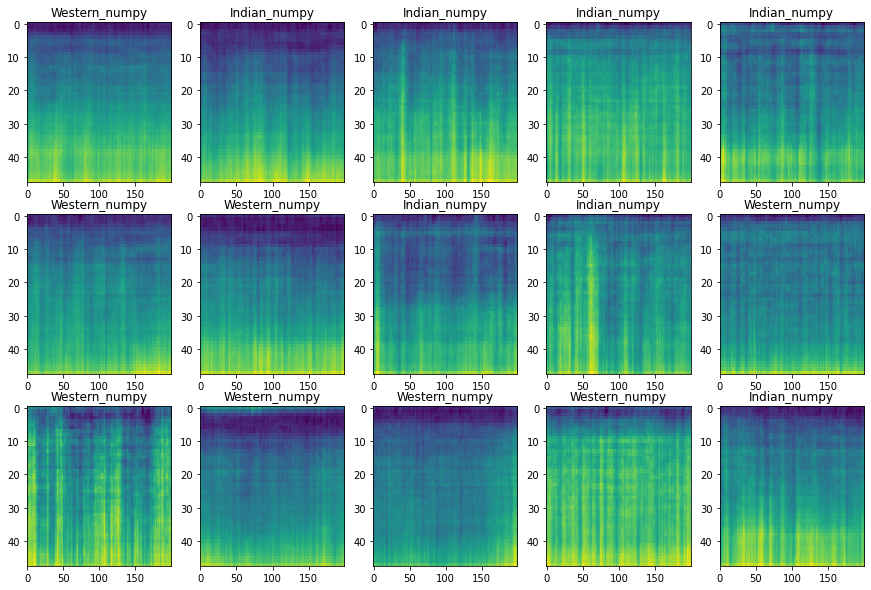

In [24]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

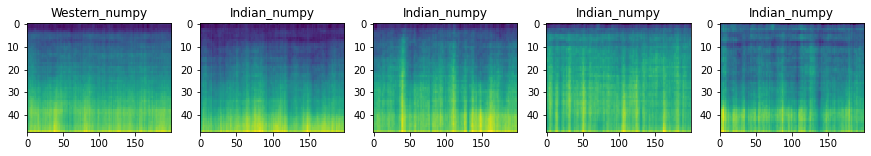

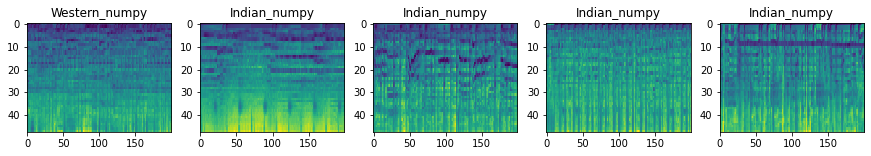

In [28]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [29]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [30]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [31]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [32]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(id_test) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(id_test) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(id_test) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(id_test) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(id_test) + ".npy"), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




In [ ]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(id_train) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(id_train) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(id_train) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(id_train) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(id_train) + ".npy"), np.transpose(orr48, (1,0)))
          id_train = id_train + 1